# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
# TF related imports
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#scikit related imports
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# other generic imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from mlxtend import plotting
from tqdm import tqdm
from datetime import timedelta
import time


2024-11-20 16:06:15.660205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 16:06:15.675819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 16:06:15.680468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 16:06:15.692309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 16:06:16.533288: W tensorflow/comp

## Global Variables

In [2]:
# global variables
PBAR_FORMAT='{desc:12} {percentage:3.0f}%|{bar:27}| [ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAPPING = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}
# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345



## Dataset, Model and Trainer

### Helper functions

In [3]:
def get_activity_code(activity_names):
    cat_len=len(activity_names)
    activity_code={}
    for idx, an in enumerate(activity_names):
        for k in ACTIVITY_CODES_MAPPING.keys() :
            if ACTIVITY_CODES_MAPPING[k]==an:
                key = k
        activity_code[key]=idx
    
    assert(len(activity_code.keys())== cat_len)
    
    print(f"{activity_code}")
    print(f"Number of Categories {cat_len}")
    return activity_code, cat_len

def sliding_window(dataset, window_size, step_size):  
    x_list, y_list, z_list = [], [], []
    targets_list = []
    for i in range(0, dataset.shape[0] - window_size, step_size):
        x_list.append(dataset["x"].values[i: i + window_size])
        y_list.append(dataset["y"].values[i: i + window_size])
        z_list.append(dataset["z"].values[i: i + window_size])
        targets_list.append(stats.mode(dataset["activity_code"][i: i + window_size])[0])

    feature_list = [x_list, y_list, z_list]

    feature_list = [np.array(data_list) for data_list in feature_list]
    dataset = np.stack(feature_list, axis = 2)

    return dataset, targets_list

### Dataset

In [4]:
def WISDM_Dataset(dir, window_size, step_size, activity_code):
    window_size = window_size
    step_size = step_size
    path = dir
    column_names = COL_NAMES
    activity_dic = activity_code
    filelist_train = sorted([txt for txt in os.listdir(path + "/") if txt[-4:] == ".txt"])
    columns = ["x", "y", "z"]
        
    # Training data
    dataset_train = pd.DataFrame()

    for txt in tqdm(filelist_train, desc="loading data", bar_format=PBAR_FORMAT):
        dataset_tmp = pd.read_csv(path + '/' + txt, header = None, names = column_names, comment = ";")
        for k in activity_dic.keys():
            df_tmp = dataset_tmp[dataset_tmp['activity_code']==k][0:2400]
            dataset_train = pd.concat([dataset_train, df_tmp])
    print(dataset_train)

    # normalize the data
    dataset_train["activity_code"] = dataset_train["activity_code"].map(activity_dic)
    labels = dataset_train["activity_code"].to_numpy()

    scaler = RobustScaler()
    dataset_train = scaler.fit_transform(dataset_train[["x", "y", "z"]])
    dataset_train = pd.DataFrame(data = dataset_train, columns = ["x", "y", "z"])
    dataset_train["activity_code"] = labels
    
    # feature engineering
    dataset_train, targets_list = sliding_window(dataset_train, window_size, step_size)
    targets = np.array(targets_list)
    return dataset_train, targets

### Model

In [5]:
def gru_net(data, num_classes):
    x_input = layer.Input(shape = (data.shape[-2:]))
    x = layer.Bidirectional(layer.GRU(512, return_sequences = True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(256, return_sequences = True))(x)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(128, return_sequences = True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation = "relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(num_classes, activation = "softmax")(x)

    model = Model(inputs = x_input, outputs = x_output, name = "GRU_NET")

    return model


### Plotting function

In [6]:
def plot_loss_acc(epochs, train_losses, train_acc, test_losses, test_acc, fold):
    fig, ax1 = plt.subplots()
    xaxis = list(range(1, epochs + 1))
    plt_train_loss = ax1.plot(xaxis, train_losses, label = "Training Loss", color="red")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    plt_train_acc = ax2.plot(xaxis, train_acc, label = "Training Accuracy", color="green")
    ax2.set_ylabel("Accuracy in %")
    ax2.set_ylim(0.0, 100.0)

    plt_val_loss = ax1.plot(xaxis, test_losses, label = "Validation Loss", color="firebrick")
    plt_val_acc = ax2.plot(xaxis, test_acc, label = "Validation Accuracy", color="limegreen")

    lines = plt_train_loss + plt_train_acc + plt_val_loss + plt_val_acc
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)
    fold = " Fold " + str(fold) 
    plt.title("Loss and Accuracy" + fold)
    plt.show()

def plot_confusion_matrix(y_pred, y_valid, fold):
    conf_matrix = confusion_matrix(y_valid, y_pred)
    plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                                   class_names = ACTIVITY_NAMES,
                                   show_normed = True,
                                   figsize = (10, 7),
                                   colorbar = True)
    plt.title("Confusion matrix Fold " + str(fold))
    plt.show()



### Trainer function

In [7]:

def train(nn_net, cat_len, batch_size, num_epochs, k_fold, train_ds, target_ds):
    val_acc_last = []
    
    training_data={}
    start_time = time.time()
    for fold, (train_index, test_index) in enumerate(k_fold.split(train_ds, target_ds)):
        print(f"Running fold: {fold}")
        x_train, x_valid = train_ds[train_index], train_ds[test_index]
        y_train, y_valid = target_ds[train_index], target_ds[test_index]
        
        # convert to tf dataset
        train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).with_options(options)
        valid_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size).with_options(options)
        
        model = nn_net(train_ds, cat_len)
        
        model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
        
        learning_rate = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = VERBOSE)
        early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, verbose = VERBOSE, mode = "min", 
                                       restore_best_weights = True)
        
        # model training
        model_data = model.fit(train_data, 
                                validation_data = valid_data, 
                                epochs = num_epochs,
                                verbose = VERBOSE,
                                batch_size = BATCH_SIZE, 
                                callbacks = [learning_rate, early_stopping])        
        val_acc_last.append(np.around(100.0 * model_data.history["val_accuracy"][-1], 2))

        y_pred = np.argmax(model.predict(valid_data, batch_size = BATCH_SIZE), axis = 1)

        training_data[fold] = {'model_data':model_data,
                               'y_pred': y_pred, 
                               'y_valid':y_valid}
        print(f'Time elapsed: {timedelta(microseconds=int((time.time()-start_time)*1000000))}')
    
    print(f'Total Training Time: {timedelta(seconds=int(time.time()-start_time))}')
    print("Val Acc per fold:", val_acc_last)
    return training_data


## Training on phone accelerometer

### Hyper parameters

In [8]:
#ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "kicking soccer ball"]
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup", 
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball", 
                  "writing", "clapping", "folding clothes"]
NUM_EPOCHS = 90
BATCH_SIZE = 256
WINDOW_SIZE=200
STEP_SIZE=100
NUM_SPLITS=5
NN_NET = gru_net
DATA_DIR="../dataset/raw/phone/accel"

### Initialize Dataset

In [9]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
# Dataset
train_ds, target_ds = WISDM_Dataset(dir = DATA_DIR,
                              window_size = WINDOW_SIZE,
                              step_size = STEP_SIZE,
                              activity_code = activity_code)
k_fold = KFold(n_splits = NUM_SPLITS,
           shuffle = True,
           random_state = RANDOM_STATE)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


loading data 100%|███████████████████████████| [   51/  51, 00:15<00:00 ]


          id activity_code        timestamp         x          y         z
0       1600             A  252207666810782 -0.364761   8.793503  1.055084
1       1600             A  252207717164786 -0.879730   9.768784  1.016998
2       1600             A  252207767518790  2.001495  11.109070  2.619156
3       1600             A  252207817872794  0.450623  12.651642  0.184555
4       1600             A  252207868226798 -2.164352  13.928436 -4.422485
...      ...           ...              ...       ...        ...       ...
154242  1650             S  357602446012000 -8.763377  -3.745811 -2.277664
154243  1650             S  357602466108000 -8.895103  -3.717071 -2.919529
154244  1650             S  357602486288000 -8.631651  -3.836822 -3.475173
154245  1650             S  357602506384000 -8.270002  -4.102669 -2.859653
154246  1650             S  357602526598000 -8.183782  -4.315825 -1.733994

[1821600 rows x 6 columns]


### Model Summary

In [10]:
model = NN_NET(train_ds, cat_len)
print(model.summary())

2024-11-20 16:06:42.221051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6634 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "GRU_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 1024)      │     1,588,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 512)       │     1,969,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 256)       │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,613,775 (40.49 MB)

 Trainable params: 10,609,935 (40.47 MB)

 Non-trainable params: 3,840 (15.00 KB)

None


### Training

In [11]:
training_data = train(nn_net=NN_NET,
                      cat_len=cat_len,
                      batch_size=BATCH_SIZE,
                      num_epochs=NUM_EPOCHS,
                      k_fold=k_fold,
                      train_ds=train_ds,
                      target_ds=target_ds)

Running fold: 0
Epoch 1/90


2024-11-20 16:06:47.888394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 344ms/step - accuracy: 0.1034 - loss: 3.8177 - val_accuracy: 0.0900 - val_loss: 3.0344 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - accuracy: 0.1247 - loss: 3.1782 - val_accuracy: 0.0760 - val_loss: 2.8573 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.1620 - loss: 2.9442 - val_accuracy: 0.1054 - val_loss: 2.9074 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.1805 - loss: 2.7247 - val_accuracy: 0.1093 - val_loss: 2.7655 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.2104 - loss: 2.5243 - val_accuracy: 0.1241 - val_loss: 2.6582 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.2415 - loss: 2.3789 - val_accuracy: 0.1631 - val_loss: 2.3976 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.2451 - loss: 2.3747 - val_

### Plot loss and accuracy

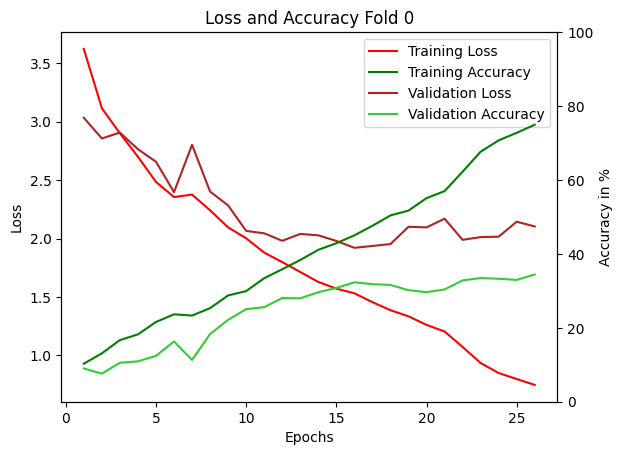

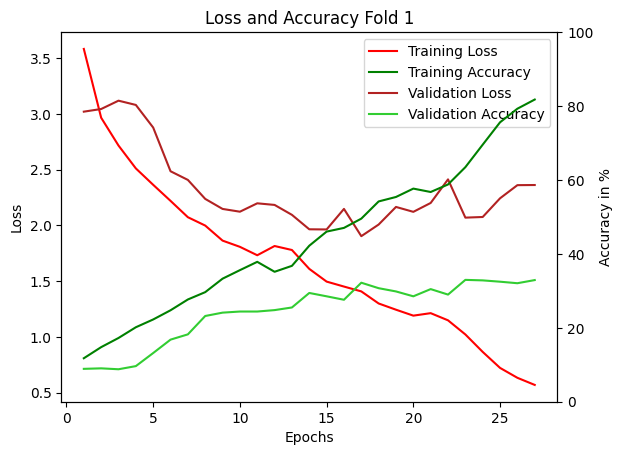

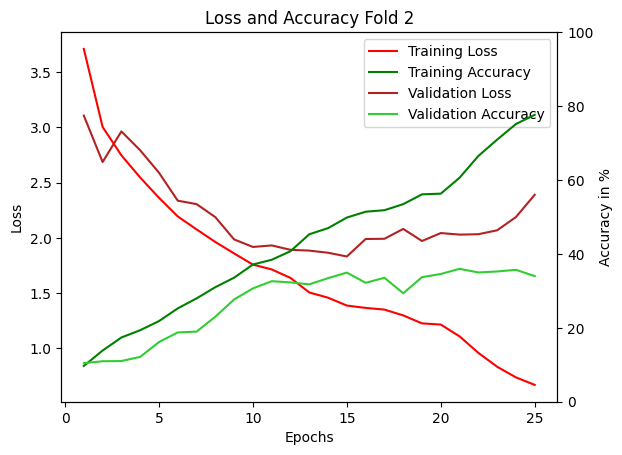

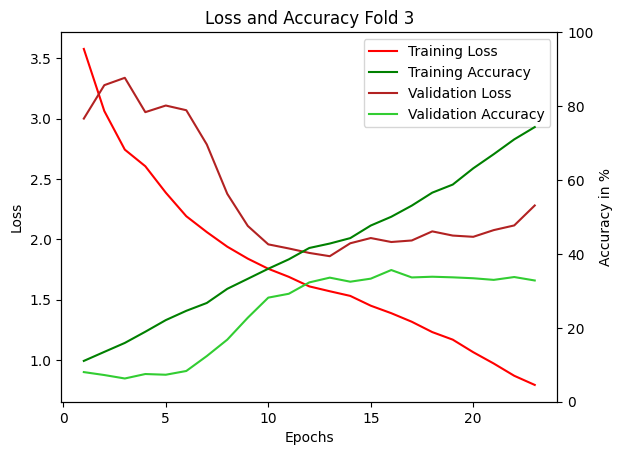

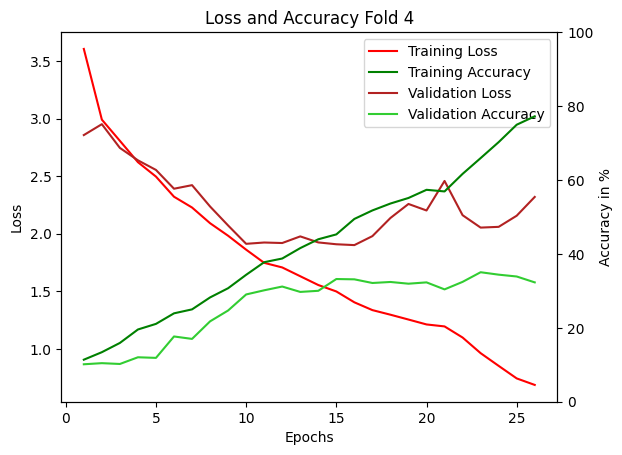

In [12]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    plot_loss_acc(len(model_data.history["loss"]), model_data.history["loss"], 
                              [acc * 100.0 for acc in model_data.history["accuracy"]], 
                              model_data.history["val_loss"], 
                              [acc * 100.0 for acc in model_data.history["val_accuracy"]], str(k))
        


### Plot Confusion matrix

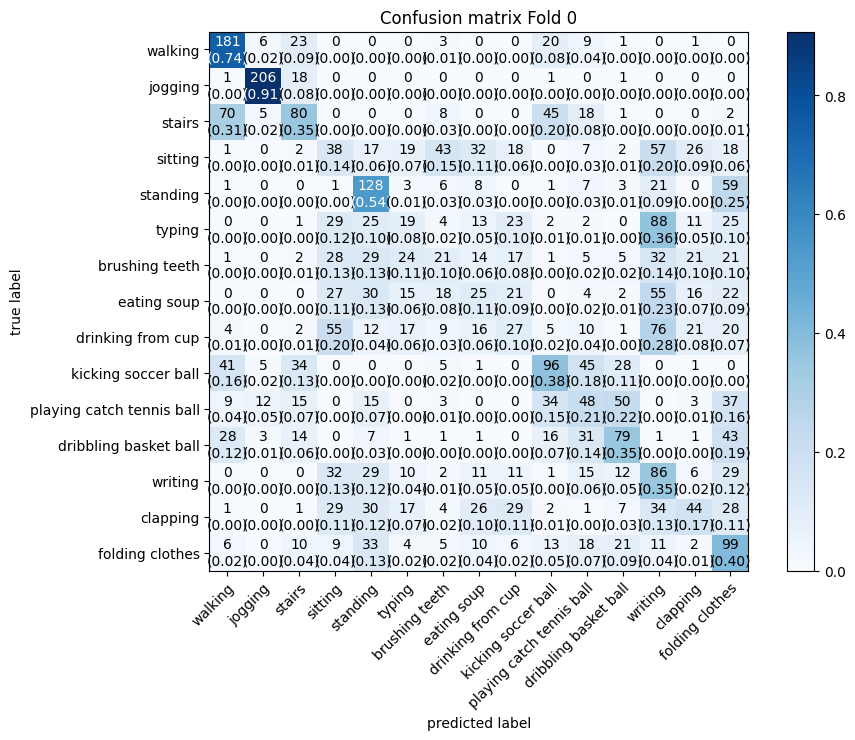

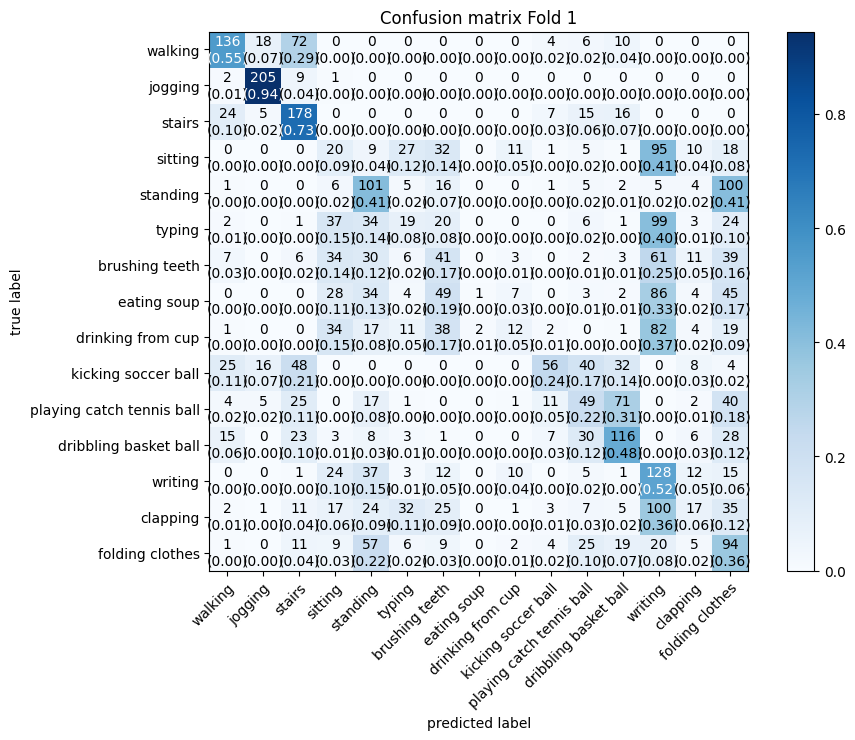

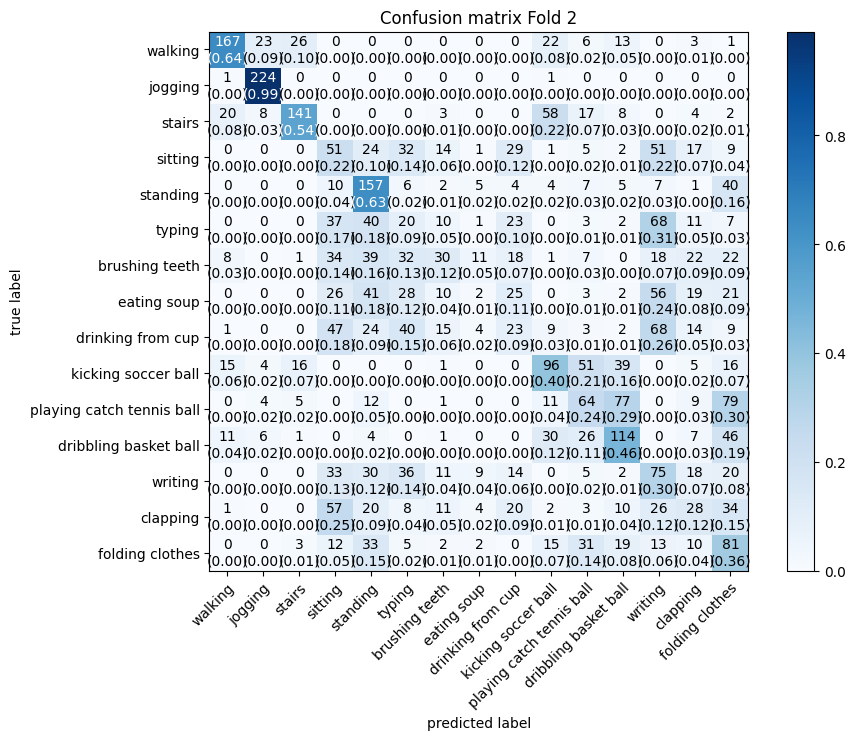

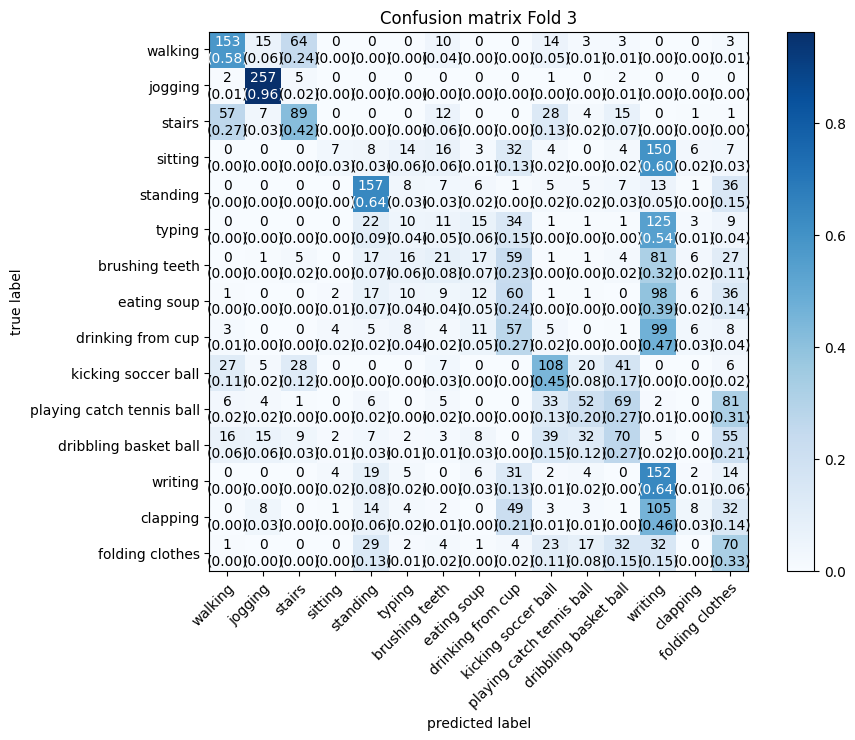

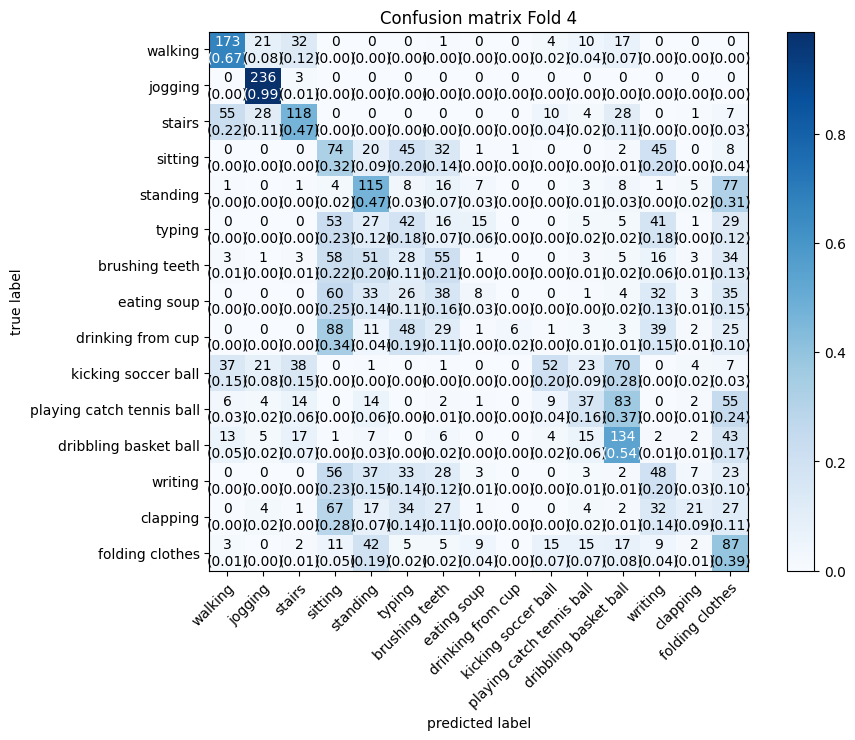

In [13]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    y_pred = training_data[k]['y_pred']
    y_valid = training_data[k]['y_valid']
    plot_confusion_matrix(y_pred, y_valid, k) 


### Accuracy Per Fold

In [14]:
print("Validation Accuracy fold wise")
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    val_acc = np.around(100.0 * model_data.history["val_accuracy"][-1], 2)
    print(f"fold {k}: {val_acc}")

Validation Accuracy fold wise
fold 0: 34.42
fold 1: 32.91
fold 2: 33.98
fold 3: 32.8
fold 4: 32.29


### Classification metric

In [15]:
for k in training_data.keys():
    # F1 score
    y_pred = training_data[k]['y_pred']
    y_valid = training_data[k]['y_valid']
    print(f"Classification report for fold {k}")
    print(classification_report(y_true=y_valid,
                                y_pred=y_pred))

Classification report for fold 0
              precision    recall  f1-score   support

           0       0.53      0.74      0.62       244
           1       0.87      0.91      0.89       227
           2       0.40      0.35      0.37       229
           3       0.15      0.14      0.14       280
           4       0.36      0.54      0.43       238
           5       0.15      0.08      0.10       242
           6       0.16      0.10      0.12       221
           7       0.16      0.11      0.13       235
           8       0.18      0.10      0.13       275
           9       0.41      0.38      0.39       256
          10       0.22      0.21      0.22       226
          11       0.37      0.35      0.36       226
          12       0.19      0.35      0.24       244
          13       0.29      0.17      0.22       253
          14       0.25      0.40      0.30       247

    accuracy                           0.32      3643
   macro avg       0.31      0.33      0.31    

## Training on phone gyroscope sensor

### Hyper parameters

In [16]:
#ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "kicking soccer ball"]
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup", 
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball", 
                  "writing", "clapping", "folding clothes"]
NUM_EPOCHS = 90
BATCH_SIZE = 256
WINDOW_SIZE=200
STEP_SIZE=100
NUM_SPLITS=5
NN_NET = gru_net
DATA_DIR="../dataset/raw/phone/gyro"

### Initialize Dataset

In [17]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
# Dataset
train_ds, target_ds = WISDM_Dataset(dir = DATA_DIR,
                              window_size = WINDOW_SIZE,
                              step_size = STEP_SIZE,
                              activity_code = activity_code)
k_fold = KFold(n_splits = NUM_SPLITS,
           shuffle = True,
           random_state = RANDOM_STATE)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


loading data 100%|███████████████████████████| [   51/  51, 00:12<00:00 ]


         id activity_code        timestamp         x         y         z
0      1600             A  252207918580802 -0.853210  0.297226  0.890182
1      1600             A  252207968934806 -0.875137  0.015472  0.162231
2      1600             A  252208019288809 -0.720169  0.388489 -0.284012
3      1600             A  252208069642813 -0.571640  1.227402 -0.241669
4      1600             A  252208119996817 -0.380493  1.202835 -0.213135
...     ...           ...              ...       ...       ...       ...
78280  1650             S  357650830694000  0.687096  0.087352  0.167247
78281  1650             S  357650870975000  0.417584 -0.095874  0.056459
78282  1650             S  357650911282000  0.096939 -0.083091 -0.028762
78283  1650             S  357650951562000 -0.242880 -0.164051 -0.102265
78284  1650             S  357650992561000 -0.543285 -0.302535 -0.196009

[1819200 rows x 6 columns]


### Model Summary

In [18]:
model = NN_NET(train_ds, cat_len)
print(model.summary())

Model: "GRU_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 200, 1024)      │     1,588,224 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 200, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 200, 512)       │     1,969,152 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 200, 256)       │       493,056 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,613,775 (40.49 MB)

 Trainable params: 10,609,935 (40.47 MB)

 Non-trainable params: 3,840 (15.00 KB)

None


### Training

In [19]:
training_data = train(nn_net=NN_NET,
                      cat_len=cat_len,
                      batch_size=BATCH_SIZE,
                      num_epochs=NUM_EPOCHS,
                      k_fold=k_fold,
                      train_ds=train_ds,
                      target_ds=target_ds)

Running fold: 0
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.1916 - loss: 2.8721 - val_accuracy: 0.1795 - val_loss: 2.3658 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.2715 - loss: 2.1547 - val_accuracy: 0.2691 - val_loss: 2.0190 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.3296 - loss: 1.9302 - val_accuracy: 0.3211 - val_loss: 1.8874 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.3711 - loss: 1.8036 - val_accuracy: 0.3458 - val_loss: 1.8492 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.4499 - loss: 1.5713 - val_accuracy: 0.3741 - val_loss: 1.8367 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.4864 - loss: 1.4436 - val_accuracy: 0.4101 - val_loss: 1.7206 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0

### Plot loss and accuracy

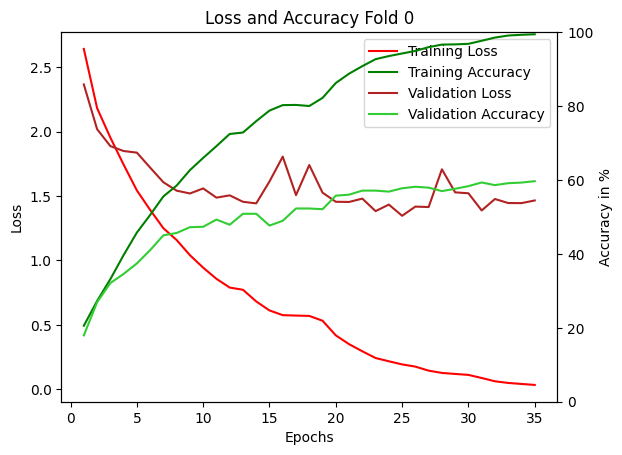

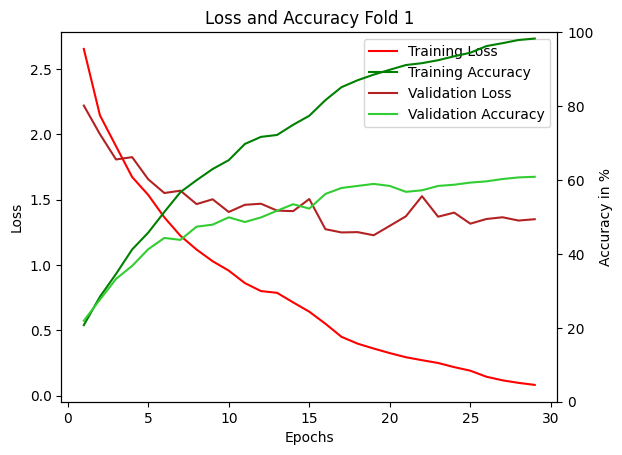

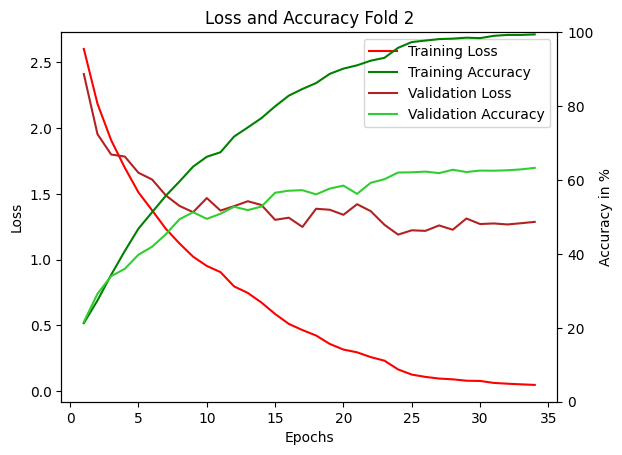

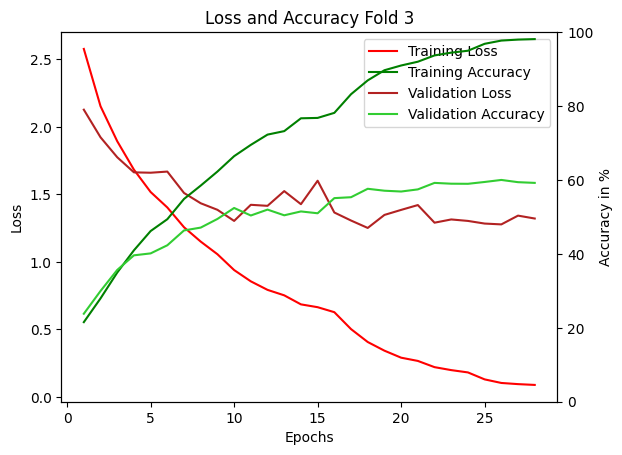

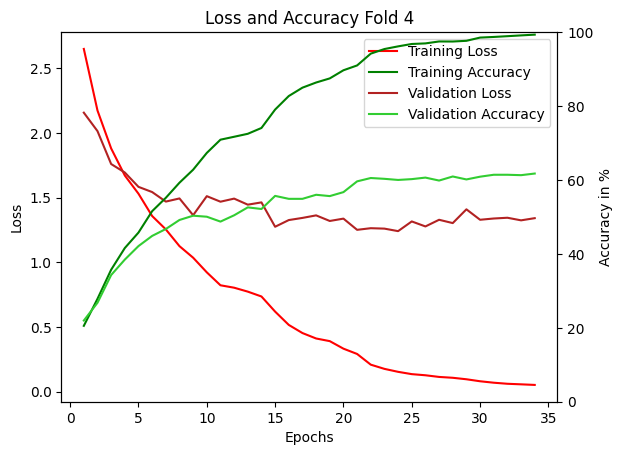

In [20]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    plot_loss_acc(len(model_data.history["loss"]), model_data.history["loss"], 
                              [acc * 100.0 for acc in model_data.history["accuracy"]], 
                              model_data.history["val_loss"], 
                              [acc * 100.0 for acc in model_data.history["val_accuracy"]], str(k))
        


### Plot Confusion matrix

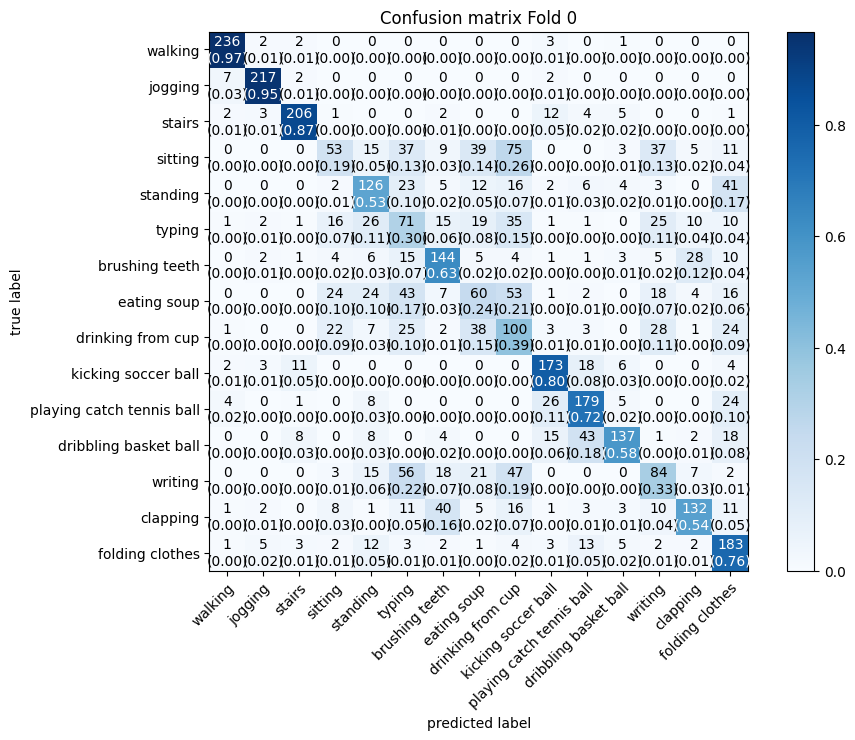

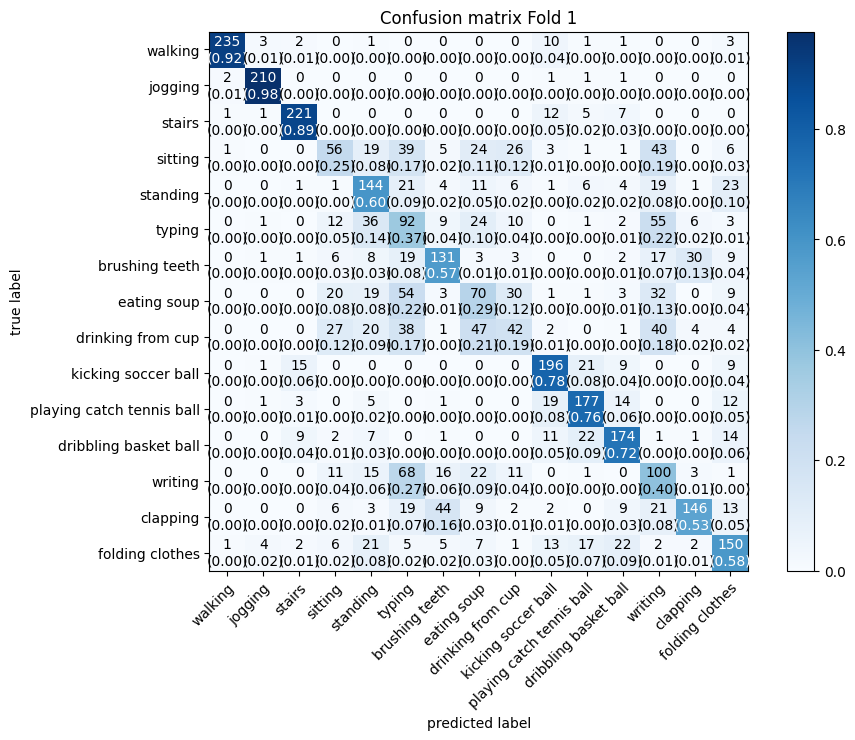

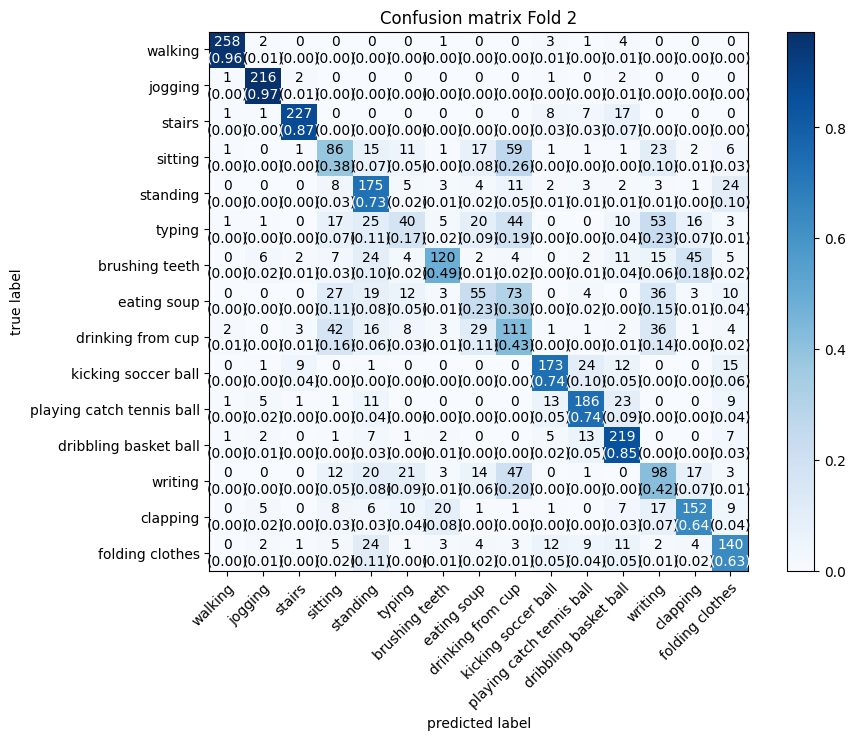

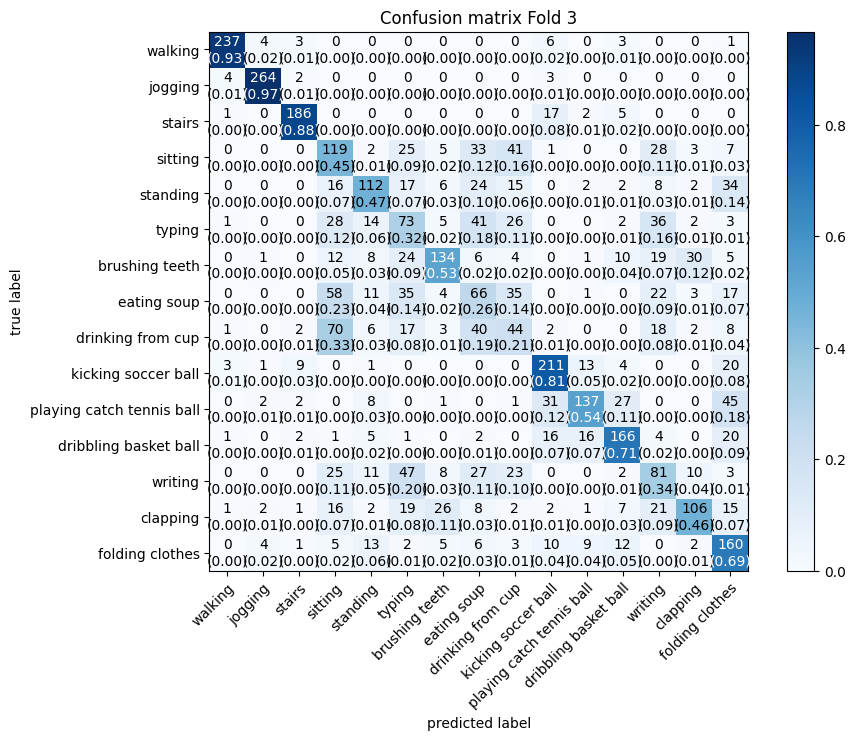

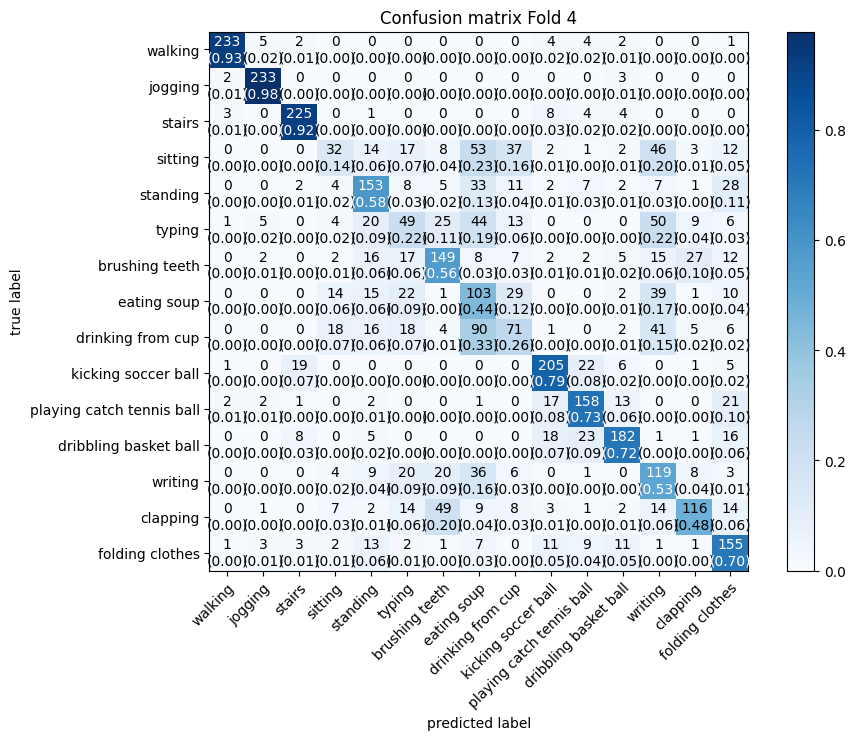

In [21]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    y_pred = training_data[k]['y_pred']
    y_valid = training_data[k]['y_valid']
    plot_confusion_matrix(y_pred, y_valid, k) 


### Accuracy Per Fold

In [22]:
print("Validation Accuracy fold wise")
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    val_acc = np.around(100.0 * model_data.history["val_accuracy"][-1], 2)
    print(f"fold {k}: {val_acc}")

Validation Accuracy fold wise
fold 0: 59.68
fold 1: 60.86
fold 2: 63.28
fold 3: 59.21
fold 4: 61.74


### Classification metric

In [23]:
for k in training_data.keys():
    # F1 score
    y_pred = training_data[k]['y_pred']
    y_valid = training_data[k]['y_valid']
    print(f"Classification report for fold {k}")
    print(classification_report(y_true=y_valid,
                                y_pred=y_pred))

Classification report for fold 0
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       244
           1       0.92      0.95      0.94       228
           2       0.88      0.87      0.87       236
           3       0.39      0.19      0.25       284
           4       0.51      0.53      0.52       240
           5       0.25      0.30      0.27       233
           6       0.58      0.63      0.60       229
           7       0.30      0.24      0.27       252
           8       0.29      0.39      0.33       254
           9       0.71      0.80      0.75       217
          10       0.66      0.72      0.69       247
          11       0.80      0.58      0.67       236
          12       0.39      0.33      0.36       253
          13       0.69      0.54      0.61       244
          14       0.52      0.76      0.61       241

    accuracy                           0.58      3638
   macro avg       0.59      0.59      0.58    